## Arm Reaching - RM - Sub 20

In [2]:
# !pip install mne

import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [3]:
# folder_path=r'/content/drive/MyDrive/eeg-raw-data-RM'
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_realMove.eeg
session1_sub10_reaching_realMove.vhdr
session1_sub10_reaching_realMove.vmrk
session1_sub11_reaching_realMove.eeg
session1_sub11_reaching_realMove.vhdr
session1_sub11_reaching_realMove.vmrk
session1_sub12_reaching_realMove.eeg
session1_sub12_reaching_realMove.vhdr
session1_sub12_reaching_realMove.vmrk
session1_sub13_reaching_realMove.eeg
session1_sub13_reaching_realMove.vhdr
session1_sub13_reaching_realMove.vmrk
session1_sub14_reaching_realMove.eeg
session1_sub14_reaching_realMove.vhdr
session1_sub14_reaching_realMove.vmrk
session1_sub15_reaching_realMove.eeg
session1_sub15_reaching_realMove.vhdr
session1_sub15_reaching_realMove.vmrk
session1_sub16_reaching_realMove.eeg
session1_sub16_reaching_realMove.vhdr
session1_sub16_reaching_realMove.vmrk
session1_sub17_reaching_realMove.eeg
session1_sub17_reaching_realMove.vhdr
session1_sub17_reaching_realMove.vmrk
session1_sub18_reaching_realMove.eeg
session1_sub18_reaching_realMove.vhdr
session1_sub18_reachi

In [4]:
eeg,vhdr,vmrk = [],[],[]

for i in folder_files:
    file=folder_path+'\\'+i
    if '.eeg' in file:
        eeg.append(file)
    elif '.vhdr' in file:
        vhdr.append(file)
    else:
        vmrk.append(file)

for i in range(0,len(eeg)):
    print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\A

### Read Raw Signals

In [5]:
raw = mne.io.read_raw_brainvision(vhdr[11], misc='auto', scale=1.0, preload=True, verbose=None)
raw # OR raw.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub20_reaching_realMove.vhdr...
Setting channel info structure...
Reading 0 ... 8449599  =      0.000 ...  3379.840 secs...


<RawBrainVision | session1_sub20_reaching_realMove.eeg, 71 x 8449600 (3379.8 s), ~4.47 GB, data loaded>

In [6]:
raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: 2019-07-31 10:23:39 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [7]:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

bad channels: []
2500.0 Hz
None 



Using matplotlib as 2D backend.


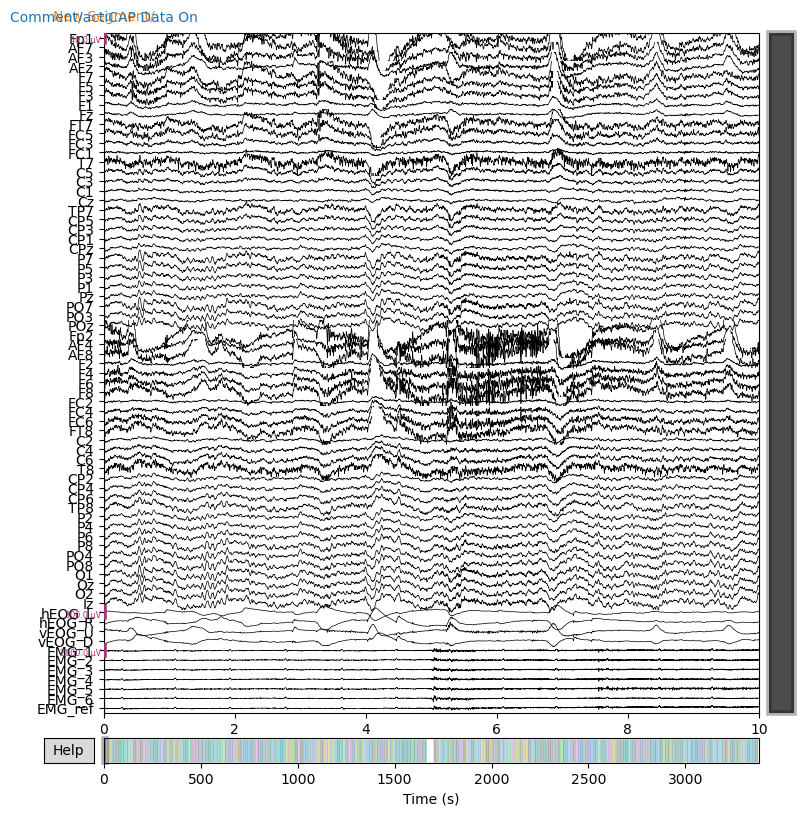

In [8]:
raw.plot(n_channels=71);

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials

 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )

 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds

In [9]:
print('First Time : ',raw.first_time)
print('Last Time  : ',raw._last_time)

First Time :  0.0
Last Time  :  3379.8396


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [10]:
print('Total Samples : ',len(raw))
print('Start : ',raw._first_samps)
print('End : ',raw._last_samps)

Total Samples :  8449600
Start :  [0]
End :  [8449599]


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [11]:
print(raw.time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [12]:
raw.pick_types(emg=False, eeg=True, eog=False)
print(len(raw.ch_names))

60


### We Will Select Channels According to International Standard 10–20 system

<!-- <img src="The-location-map-of-32-channels-cap-The-electrodes-can-be-divided-into-3-groups.png" style="width:400px;hight:400;"/> -->

In [ ]:
# print(raw.ch_names)

In [ ]:
# selected_channels = ["Fp1", "AF3","F7","F3","FC1","FC5","T7","C3","CP1","CP5","P7","P3", "PO3", "O1",  # Brain Left Side
#                      "Fz","Cz","Pz","Oz",                                                              # Brain Mid
#                      "O2","FC2","F4","F8","AF4","Fp2","C4", "T8","FC6","CP2","PO4","P4","P8","CP6",    # Brain Right Side
#                      "hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"]                                           # EOG Channels

In [ ]:
# raw.pick_channels(ch_names=selected_channels)
# montage = mne.channels.make_standard_montage('standard_1020')
# raw.set_montage(montage)
# print(len(raw.ch_names))

In [ ]:
# raw.plot(n_channels=36);

In [ ]:
# raw.plot_sensors(show_names=True,sphere=0.11);
# fig = montage.plot(kind='3d',show=False)
# fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

### Bandpass Filtering the Data
- Filtering to remove slow drift.
- Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [13]:
raw.filter(l_freq=8, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4125 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   34.3s finished


<RawBrainVision | session1_sub20_reaching_realMove.eeg, 60 x 8449600 (3379.8 s), ~3.78 GB, data loaded>

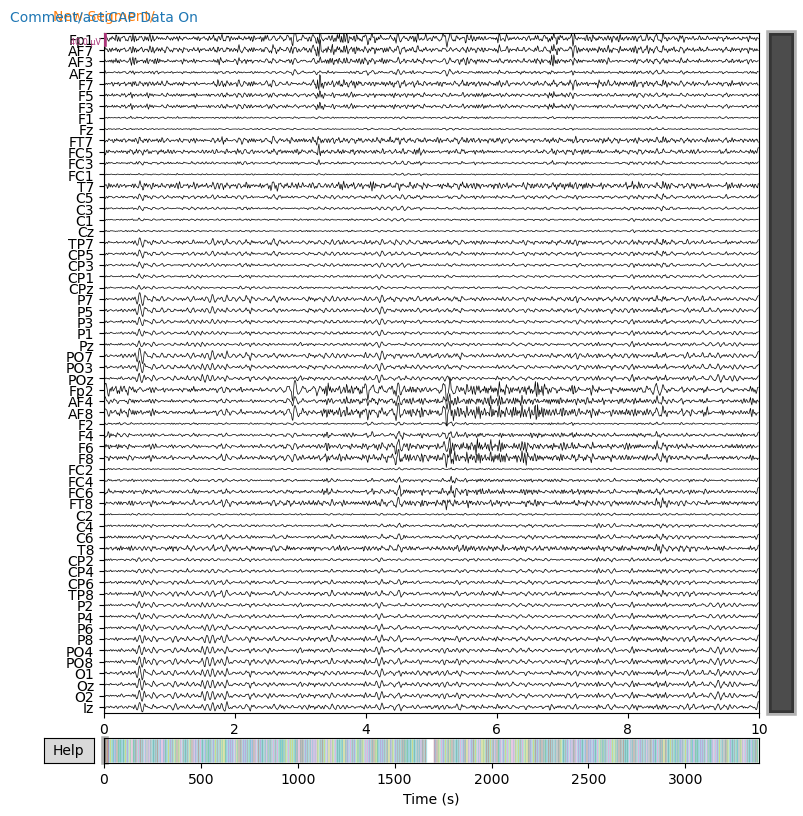

In [14]:
raw.plot(n_channels=60);

In [16]:
spectrum = raw.compute_psd()
spectrum.plot(average=True);

Effective window size : 0.102 (s)


In [17]:
raw.set_montage('easycap-M1')

<RawBrainVision | session1_sub20_reaching_realMove.eeg, 60 x 8449600 (3379.8 s), ~3.78 GB, data loaded>

### Refrencing EEG

In [18]:
# Average reference. This is normally added by default, but can also be added
# explicitly.
raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | session1_sub20_reaching_realMove.eeg, 60 x 8449600 (3379.8 s), ~3.78 GB, data loaded>

### Read Events & Epoching

In [19]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [20]:
events

(array([[      0,       0,   99999],
        [      0,       0,   10001],
        [  37816,       0,      13],
        ...,
        [8410346,       0,      31],
        [8420391,       0,       8],
        [8425402,       0,      14]]),
 {'Comment/actiCAP Data On': 10001,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  6': 6,
  'Stimulus/S  8': 8,
  'Stimulus/S 11': 11,
  'Stimulus/S 13': 13,
  'Stimulus/S 14': 14,
  'Stimulus/S 21': 21,
  'Stimulus/S 31': 31,
  'Stimulus/S 41': 41,
  'Stimulus/S 51': 51,
  'Stimulus/S 61': 61})

In [21]:
selected_events = mne.pick_events(events[0], exclude=[99999,10001,10002,10003,1,2,3,4,5,6,13,14])
selected_events

array([[  55402,       0,      21],
       [  65447,       0,       8],
       [  83041,       0,      61],
       ...,
       [8392762,       0,       8],
       [8410346,       0,      31],
       [8420391,       0,       8]])

In [22]:
print(selected_events.shape)

(600, 3)


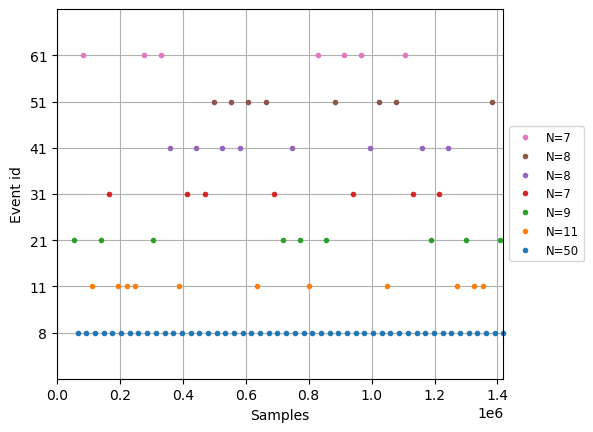

In [24]:
mne.viz.plot_events(selected_events[:100]);

In [29]:
event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
epochs = mne.Epochs(raw, events=selected_events, event_id=event_ids, tmin=0, tmax=7, preload=True,baseline=(0, 0))

Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 17501 original time points ...


0 bad epochs dropped


In [30]:
epochs

<Epochs |  300 events (all good), 0 - 7 sec, baseline 0 – 0 sec, ~2.35 GB, data loaded,
 'Stimulus/S 11': 50
 'Stimulus/S 21': 50
 'Stimulus/S 31': 50
 'Stimulus/S 41': 50
 'Stimulus/S 51': 50
 'Stimulus/S 61': 50>

In [31]:
print(epochs.get_data().shape)

(300, 60, 17501)


In [32]:
epochs.crop(tmin=3,tmax=7,include_tmax=True)
epochs.get_data().shape

(300, 60, 10001)

### Epochs Downsampling

In [33]:
epochs.resample(sfreq=1250)
epochs.get_data().shape

(300, 60, 5000)

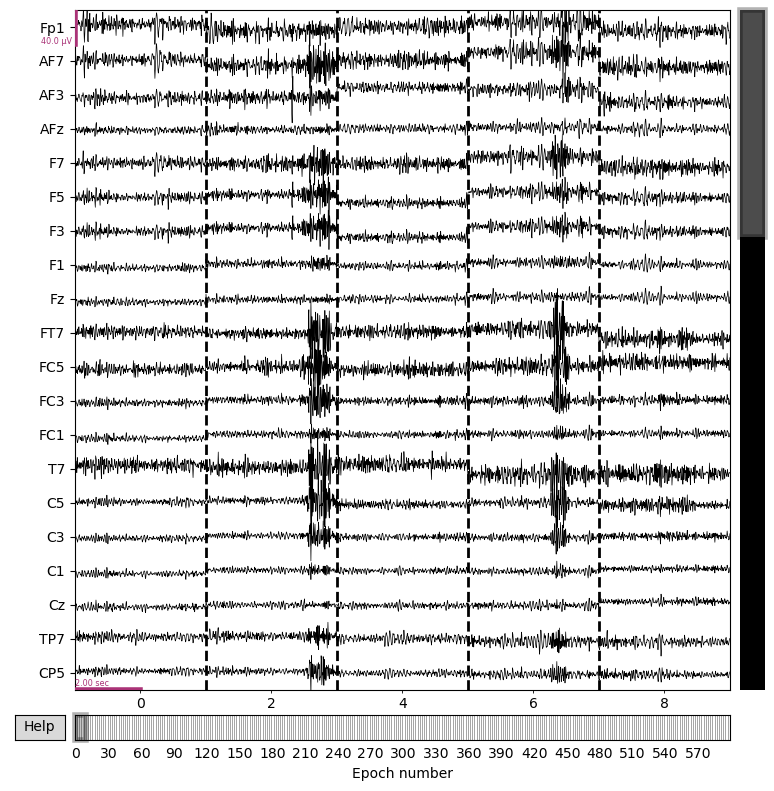

In [34]:
epochs.plot(n_epochs=5);

### Repairing artifacts with ICA
Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [36]:
epochs.set_montage('easycap-M1')

<Epochs |  300 events (all good), 3 - 6.9992 sec, baseline 0 – 0 sec (baseline period was cropped after baseline correction), ~686.7 MB, data loaded,
 'Stimulus/S 11': 50
 'Stimulus/S 21': 50
 'Stimulus/S 31': 50
 'Stimulus/S 41': 50
 'Stimulus/S 51': 50
 'Stimulus/S 61': 50>

In [37]:
ica = mne.preprocessing.ICA(n_components=60, max_iter='auto',random_state=42,method='fastica')
ica.fit(epochs.copy())

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 60 components
Fitting ICA took 390.0s.


<ICA | epochs decomposition, method: fastica (fit in 117 iterations on 1500000 samples), 60 ICA components (60 PCA components available), channel types: eeg, no sources marked for exclusion>

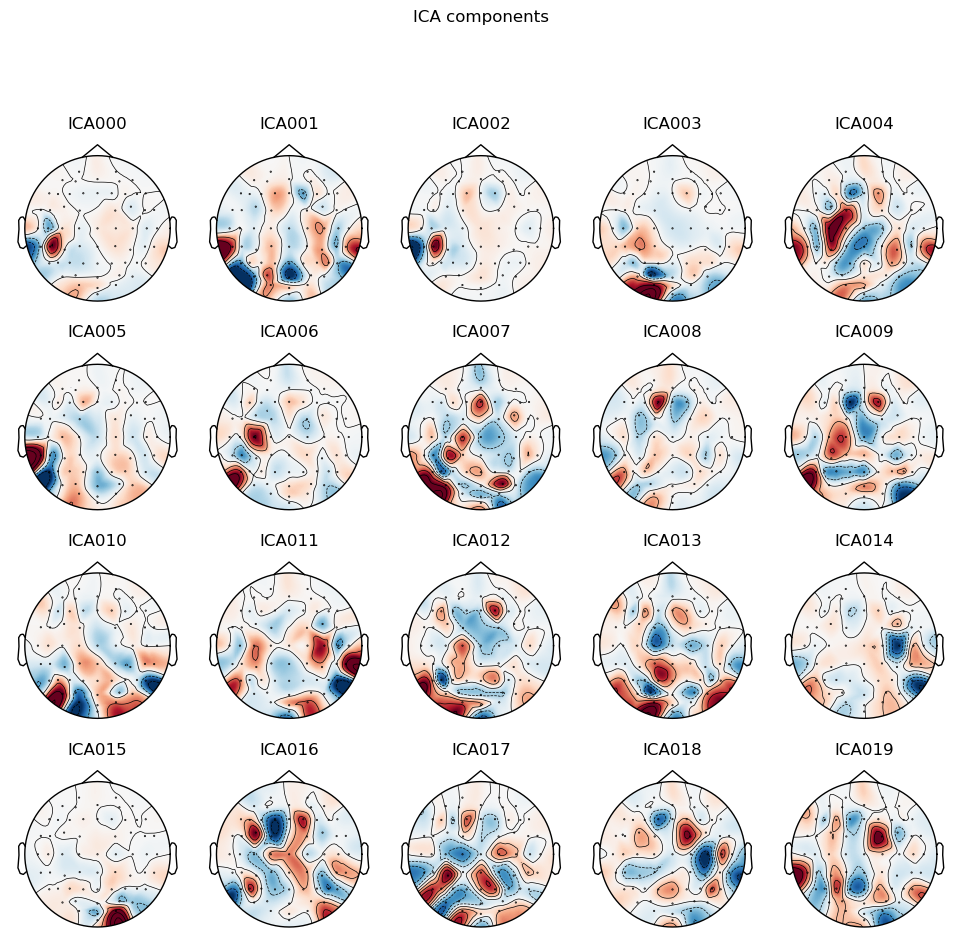

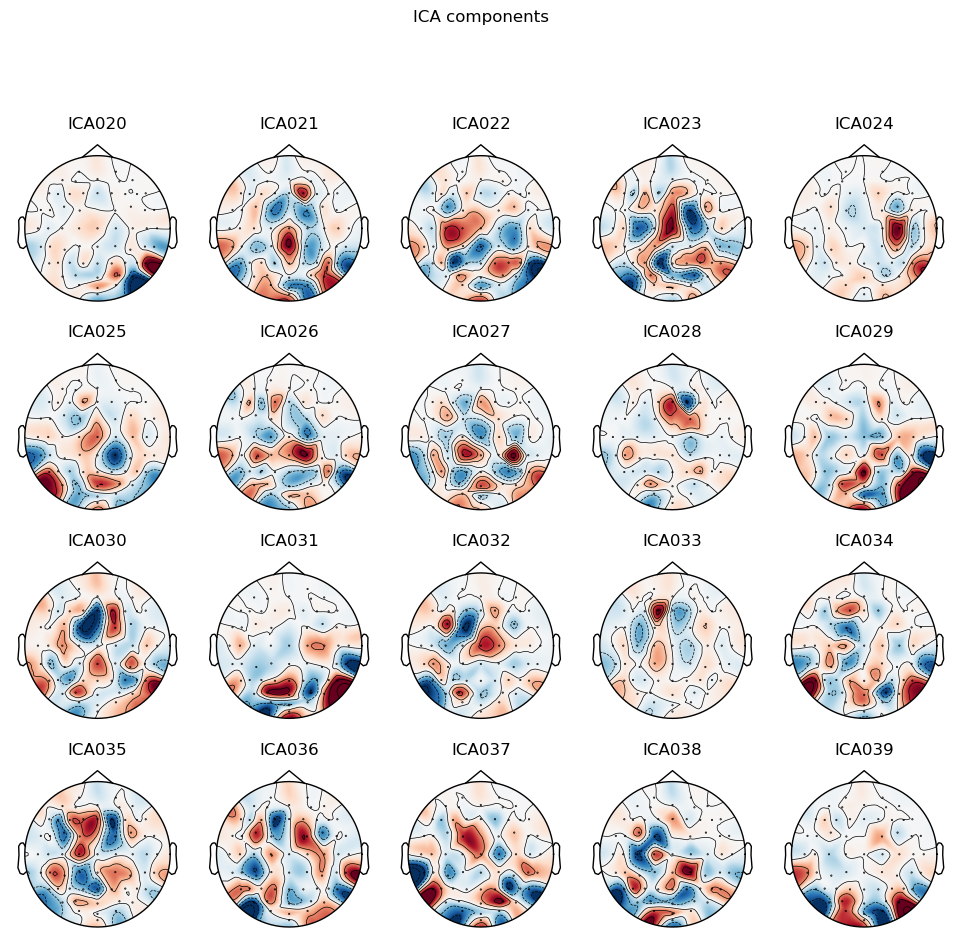

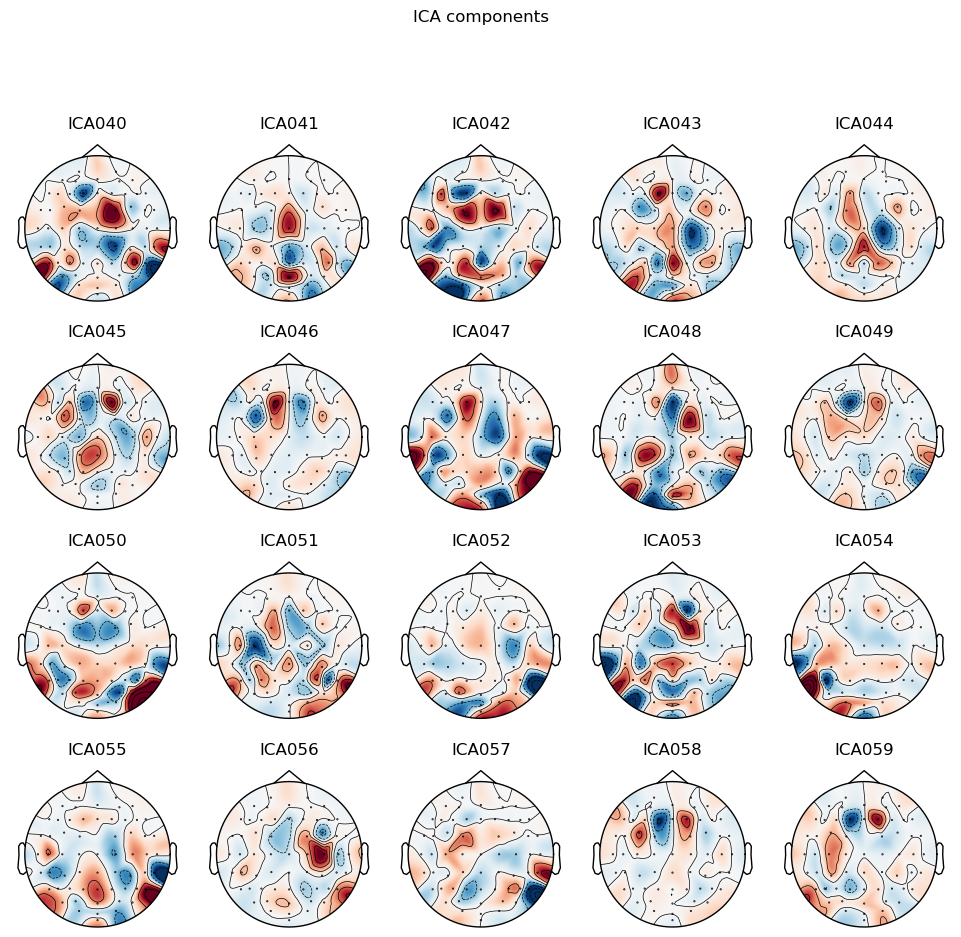

In [38]:
ica.plot_components();

In [40]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=3)
# print(bad_indx)

In [ ]:
# epochs.plot(n_epochs=5);

In [ ]:
# ica.exclude = bad_indx
# ica.apply(epochs.copy(),exclude=ica.exclude).plot(n_epochs=5);

In [ ]:
# ica.apply(epochs,exclude=ica.exclude)

In [157]:
# epochs.pick_types(eeg=True)
data = epochs.get_data()

In [158]:
labels = np.empty(shape=(300))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [159]:
data.shape , labels.shape

((300, 60, 5000), (300,))

## DWT

In [160]:
def preprocess_using_wavelet(filtered_signal):
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 5

    # db8,level 5
    # Daubechies sym7
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)

    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, wavelet)
    return res


dwt_features=preprocess_using_wavelet(data)

In [162]:
plt.plot(dwt_features[0][0])

In [163]:
dwt_features.shape , labels.shape

((300, 60, 5000), (300,))

## Select two classes

In [442]:
selected_classes = [0 , 2]

selected_labels , selected_data = np.empty(shape=(100,)) , np.empty(shape=(100, 60, 5000))
c = 0
for i in range(0, len(labels)):
    if labels[i] in selected_classes:
        selected_labels[c] = labels[i]
        selected_data[c] = dwt_features[i]
        c+=1

In [443]:
c

100

In [444]:
selected_data.shape , selected_labels.shape

((100, 60, 5000), (100,))

## Train-Test Split

In [445]:
# X_train, X_test, y_train, y_test = train_test_split(dwt_features, labels, test_size = 0.2,stratify=labels,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(selected_data, selected_labels, test_size = 0.2,stratify=selected_labels,shuffle=True)

In [446]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((80, 60, 5000), (20, 60, 5000), (80,), (20,))

## CSP

In [447]:
csp=mne.decoding.CSP(60)

X_train_csp = csp.fit_transform(X_train,y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 0.00028 (2.2e-16 eps * 60 dim * 2.1e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00039 (2.2e-16 eps * 60 dim * 2.9e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.


In [448]:
X_train_csp.shape , X_test_csp.shape

((80, 60), (20, 60))

## Traditional ML Model

## LDA

In [449]:
# ‘svd’, ‘lsqr’, ‘eigen’
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model

train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  1.0
test accuracy:   0.5


In [450]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='sigmoid', degree=10, C=20).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  1.0
test accuracy:   0.65


In [451]:
# training a linear SVM classifier

# kernel: ((...) -> Any) | Literal['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'] = "rbf",
svm_kernel_ovo = OneVsOneClassifier(SVC(kernel='sigmoid', C=10, degree=10, decision_function_shape='ovo')).fit(X_train_csp, y_train)
svm_kernel_ovr = OneVsRestClassifier(SVC(kernel='sigmoid', C=10)).fit(X_train_csp, y_train)

svm_linear_ovo = OneVsOneClassifier(LinearSVC(C=10)).fit(X_train_csp, y_train)
svm_linear_ovr = OneVsRestClassifier(LinearSVC(C=10)).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model
train_accuracy = svm_kernel_ovr.score(*evaluate_train)
test_accuracy = svm_kernel_ovr.score(*evaluate_test)
print('Linear Kernel OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_kernel_ovo.score(*evaluate_train)
test_accuracy = svm_kernel_ovo.score(*evaluate_test)
print('Linear Kernel OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovr.score(*evaluate_train)
test_accuracy = svm_linear_ovr.score(*evaluate_test)
print('LinearSVC OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovo.score(*evaluate_train)
test_accuracy = svm_linear_ovo.score(*evaluate_test)
print('LinearSVC OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

Linear Kernel OneVsRest SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.6
________________________________________
Linear Kernel OneVsOne SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.6
________________________________________
LinearSVC OneVsRest SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.6
________________________________________
LinearSVC OneVsOne SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.6
________________________________________


## AdaBoost

In [462]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=150),
                         algorithm="SAMME",
                         n_estimators=100, learning_rate=0.2)
error = []

clf = tree.DecisionTreeClassifier(max_depth=150)
clf.fit(X_train_csp,y_train)
y_prediction = clf.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Decision Tree: " + str(accuracy))

bdt.fit(X_train_csp,y_train)
y_prediction = bdt.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Adaboost: " + str(accuracy))

Decision Tree: 70.0
Adaboost: 70.0


## MLP

In [629]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(25), activation='relu')

mlp.fit(X_train_csp, y_train)

print(f"Train Accuracy: {mlp.score(X_train_csp, y_train)*100:.3f}%")
print(f"Test Accuracy: {mlp.score(X_test_csp, y_test)*100:.3f}%")

Train Accuracy: 100.000%
Test Accuracy: 60.000%
